<a href="https://colab.research.google.com/github/jx-dohwan/Aiffel_NLP_Project/blob/main/%5BNLP_10%5DCreate_a_translator_with_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [NLP_10]Create a translator with Transformer

시도해볼 것
- SentencePiece의 Supported algorithm
  - unigram
  - bpm
  - char
  - word

- 파라미터 설정 :  N은 2로 고정하라고 노드에서 제시함
  - small
    - N : 2
    - dmodel : 256
    - dff : 512
    - h : 8
    - drop : 0.1
  - base
    - N : 2
    - dmodel : 512
    - dff : 2048 
    - h : 8
    - drop : 0.1
  - big
    - N : 2
    - dmodel : 1024
    - dff : 4096
    - h : 16
    - drop :0.3
- epochs 조정 : 빠른 실험을 통해서 낮은 5 epoch를 먼저 돌려보자, 그리고 최종 모델의 선정되었을 시 논문대로 100 epochs를 돌려 결과를 비교해 선정하자

## 1. Import 및 라이브러리 다운로드

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 12 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent

In [ ]:
! pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sentencepiece as spm
import re
import os
import io
import time
import random
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm  
import seaborn # Attention 시각화를 위해 필요!
plt.rc('font', family='NanumBarunGothic')
print(tf.__version__)

2.9.2


## 2. 데이터 다운로드

In [ ]:
path_train_ko = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/transformer_translator/korean-english-park.train.ko'
path_train_en = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/transformer_translator/korean-english-park.train.en'

In [ ]:
# with open(path_train_ko, "r") as f:
#     raw_ko = f.read().splitlines()

# print("Data Size:", len(raw_ko))
# print("Example:")

# for sen in raw_ko[0:100][::20]: print(">>", sen)

In [ ]:
# with open(path_train_en, "r") as f:
#     raw_en = f.read().splitlines()

# print("Data Size:", len(raw_en))
# print("Example:")

# for sen in raw_en[0:100][::20]: print(">>", sen)

## 3. 데이터 정제 및 토큰화

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하도록 합니다. 데이터의 병렬 쌍이 흐트러지지 않게 주의하세요! 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.
<br><br>

2. 정제 함수를 아래 조건을 만족하게 정의하세요.
  - 모든 입력을 소문자로 변환합니다.
  - 알파벳, 문장부호, 한글만 남기고 모두 제거합니다.
  - 문장부호 양옆에 공백을 추가합니다.
  - 문장 앞뒤의 불필요한 공백을 제거합니다.
<br><Br>

3. 한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제하여 토큰화를 진행합니다! 토큰화에는 Sentencepiece를 활용하세요. 첨부된 공식 사이트를 참고해 아래 조건을 만족하는 generate_tokenizer() 함수를 정의합니다. 최종적으로 ko_tokenizer 과 en_tokenizer 를 얻으세요. en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행해 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.
  - https://github.com/google/sentencepiece
    - 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
    - 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load()한 후 반환합니다.
    - 특수 토큰의 인덱스를 아래와 동일하게 지정합니다.
PAD : 0 / BOS : 1 / EOS : 2 / UNK : 3
<br><Br>

4. 토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하세요! (❗모든 데이터를 사용할 경우 학습에 굉장히 오랜 시간이 걸립니다.)

### 1) set 데이터형으로 변환

In [ ]:
# 데이터 정제 및 토큰화
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(path_train_ko, path_train_en)

In [ ]:
# cleaned_corpus = list(set(zip(raw_ko, raw_en)))

In [ ]:
len(cleaned_corpus)

78968

In [ ]:
for pair in cleaned_corpus[:10]:
    print(pair)
    print('pair 0 :',pair[0])
    print('pair 1 :',pair[1])

("패스트 푸드 체인업의 원조격 맥도날드는 전세계적으로 연간 250만 파운드의 육류를 구매하는데, 이 같은 규모의 구매력은 ''축산농가에서 항생제 과다 사용 추세를 반전시키는 데 도움을 줄 수 있다’’고 환경방위의 프로그램 담당 이사 그 웬 루타씨는 말했다. 원조 (=founder or first leader)", "The father of all fast-food chains buys 2.5 million pounds of meat a year globally and with that type of purchasing power, McDonald's can ``help to reverse the trend of antibiotics overuse in animal agriculture,'' said Gwen Ruta, program director for Environmental Defense.")
pair 0 : 패스트 푸드 체인업의 원조격 맥도날드는 전세계적으로 연간 250만 파운드의 육류를 구매하는데, 이 같은 규모의 구매력은 ''축산농가에서 항생제 과다 사용 추세를 반전시키는 데 도움을 줄 수 있다’’고 환경방위의 프로그램 담당 이사 그 웬 루타씨는 말했다. 원조 (=founder or first leader)
pair 1 : The father of all fast-food chains buys 2.5 million pounds of meat a year globally and with that type of purchasing power, McDonald's can ``help to reverse the trend of antibiotics overuse in animal agriculture,'' said Gwen Ruta, program director for Environmental Defense.
('파키스탄 야당 지도자들은 대부분 교도소에 수감돼 있거나 가택연금 상태에 놓여있다.', "Most of the leaders from Pakis

### 2) 데이터 정제

In [ ]:
def preprocess_sentence(sentence, e_token=False):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()

    return sentence

### 3) SentencePiece
- https://github.com/google/sentencepiece

In [ ]:
eng_corpus = []
kor_corpus = []

#num_examples = 20000

for pair in cleaned_corpus:#[:num_examples]:
    kor_corpus.append(preprocess_sentence(pair[0]))
    eng_corpus.append(preprocess_sentence(pair[1]))

print("한국어:", kor_corpus[100])   # go away !
print("영어:", eng_corpus[100])

한국어: 차 세계대전 이후 년 유럽에서 발생한 대참사인 스레브레니차 대학살 당시 참살된 명의 남성과 남자아이들의 유골들이다 .
영어: the bones are from more than , men and boys slaughtered in during the bosnian war at srebrenica in the worst massacre in europe since world war ii .


- https://paul-hyun.github.io/vocab-with-sentencepiece/
- https://www.programcreek.com/python/example/117288/sentencepiece.SentencePieceProcessor

In [ ]:
def generate_tokenizer(corpus, Mtype, vocab_size, ko_en):
  temp_file = '/content/drive/MyDrive/인공지능/아이펠/GoingDeeper/제출용/data/transformer_translator/ratings_train_{}.txt.temp'.format(ko_en)
  model_prefix = 'spm_{}'.format(ko_en)
  with open(temp_file, 'w') as f:
      for row in corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
          f.write(str(row) + '\n')

  if Mtype == 'bpe' or Mtype == 'unigram' or Mtype == 'char'or Mtype == 'word':
    spm.SentencePieceTrainer.Train(
        f"--input={temp_file} --model_prefix={model_prefix} --vocab_size={vocab_size} --model_type={Mtype}"+
        " --pad_id=0 --pad_piece=[PAD]" + 
        " --unk_id=1 --unk_piece=[UNK]" + 
        " --bos_id=2 --bos_piece=[BOS]" + 
        " --eos_id=3 --eos_piece=[EOS]".format(temp_file, model_prefix, vocab_size, Mtype)    
    )
  else:
    print("Mtype를 잘 못 입력 했습니다 'bpe', 'unigram', 'char', 'word' 중 하나를 입력해주세요")
    if __name__ == "__main__": # 참조 : https://www.delftstack.com/ko/howto/python/python-exit-if-statement/
      load_data(0)  
      print("Broken out")
  
  #위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

  s = spm.SentencePieceProcessor()
  s.Load(model_prefix+'.model')
  if model_prefix == 'spm_en':
    s.set_encode_extra_options("bos:eos")

  return s

- bpe or unigram 선정 
  - 참고자료 : https://wikidocs.net/22592

In [ ]:
# unigram
ko_tokenizer = generate_tokenizer(kor_corpus, 'unigram', 20000, 'ko')
en_tokenizer = generate_tokenizer(eng_corpus, 'unigram', 20000, 'en')

# bpe
# ko_tokenizer = generate_tokenizer(kor_corpus, 'bpe', 20000, 'ko')
# en_tokenizer = generate_tokenizer(eng_corpus, 'bpe', 20000, 'en')

# char
# ko_tokenizer = generate_tokenizer(kor_corpus, 'char', 20000, 'ko')
# en_tokenizer = generate_tokenizer(eng_corpus, 'char', 20000, 'en')

# word
# ko_tokenizer = generate_tokenizer(kor_corpus, 'word', 20000, 'ko')
# en_tokenizer = generate_tokenizer(eng_corpus, 'word', 20000, 'en')

In [ ]:
!ls -l spm_ko*

-rw-r--r-- 1 root root 623747 Oct 14 06:18 spm_ko.model
-rw-r--r-- 1 root root 403547 Oct 14 06:18 spm_ko.vocab


In [ ]:
!ls -l spm_en*

-rw-r--r-- 1 root root 575645 Oct 14 06:19 spm_en.model
-rw-r--r-- 1 root root 355536 Oct 14 06:19 spm_en.vocab


### 4) 토큰화
- https://lsjsj92.tistory.com/600
- https://wikidocs.net/86657

In [ ]:
src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다. 
for idx in tqdm(range(len(kor_corpus))):
        ko_pair = ko_tokenizer.encode_as_ids(kor_corpus[idx])
        en_pair = en_tokenizer.encode_as_ids(eng_corpus[idx])
        if len(ko_pair) <= 50 and len(en_pair) <= 50: # 영어는 52로 지정한 이유는 eos, bos가 추가되었기 때문이다.
            src_corpus.append(ko_pair)
            tgt_corpus.append(en_pair)

# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

  0%|          | 0/78968 [00:00<?, ?it/s]

In [ ]:
# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_test, dec_train, dec_test = \
train_test_split(enc_train, dec_train, test_size=0.2)

enc_train_size = len(enc_train)
dec_train_size = len(dec_train)
enc_test_size = len(enc_test)
dec_test_size = len(dec_test)
print("한국어 train Size:", enc_train_size)
print("영어 train Size:", dec_train_size)
print("한국어 test Size:", enc_test_size)
print("영어 test Size:", dec_test_size)
print('한국어 shape : ', enc_train.shape)
print('영어 shape : ', dec_train.shape)


한국어 train Size: 57714
영어 train Size: 57714
한국어 test Size: 14429
영어 test Size: 14429
한국어 shape :  (57714, 50)
영어 shape :  (57714, 50)


In [ ]:
# src_corpus = []
# tgt_corpus = []

# num_examples = 20000

# for pair in cleaned_corpus[:num_examples]:
#     ko_pair = ko_tokenizer.encode_as_pieces(pair[0])
#     en_pair = en_tokenizer.encode_as_pieces(pair[1])
#     if len(ko_pair) >= 50 or len(en_pair) >= 52:
#         src_corpus.append(ko_pair)
#         tgt_corpus.append(en_pair)

# print("한국어:", src_corpus[100])   # go away !
# print("영어:", tgt_corpus[100])

In [ ]:
# def tokenize(corpus):
#     tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
#     tokenizer.fit_on_texts(corpus)

#     tensor = tokenizer.texts_to_sequences(corpus)

#     tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

#     return tensor, tokenizer

In [ ]:
# # 토큰화하기
# enc_tensor, enc_tokenizer = tokenize(src_corpus)
# dec_tensor, dec_tokenizer = tokenize(tgt_corpus)

# # 훈련 데이터와 검증 데이터로 분리하기
# enc_train, enc_val, dec_train, dec_val = \
# train_test_split(enc_train, dec_train, test_size=0.2)

# print("한국어 Vocab Size:", len(enc_tokenizer.index_word))
# print("영어 Vocab Size:", len(dec_tokenizer.index_word))

## 4. 모델 설계

In [ ]:
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
            

    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
    				        
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

In [ ]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn
 

In [ ]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [ ]:
def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

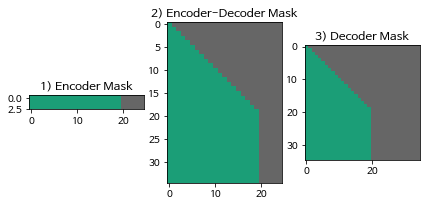

In [ ]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

In [ ]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

## 5. 훈련하기

1. 2 Layer를 가지는 Transformer를 선언하세요.
(하이퍼파라미터는 자유롭게 조절합니다.)
<br><br>
2. 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하세요. (Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.)
<br><br>
3. Loss 함수를 정의하세요.
Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking 되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)
<br><br>
4. train_step 함수를 정의하세요.
입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.
<br><br>
5. 학습을 진행합니다.
매 Epoch 마다 제시된 예문에 대한 번역을 생성하고, 멋진 번역이 생성되면 그때의 하이퍼파라미터와 생성된 번역을 제출하세요!


### 1) 2 Layer를 가지는 Transformer를 선언
- 클래스에 대한 이해가 부족한 것 같음

In [ ]:
transformer = Transformer(n_layers=2, 
                          d_model=512,
                          n_heads=8,
                          d_ff=2048,
                          src_vocab_size = enc_train_size,
                          tgt_vocab_size = dec_train_size,
                          pos_len=50,
                          dropout=0.1,
                          shared=True)

### 2) learning rate scheduler & Adam Optimizer 선언

In [ ]:
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9,
                                     name='Adam')

### 3) Loss 함수 정의

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

### 4) train_step 함수 정의
- optimizer.apply_gradients() 사용법
  - https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer
- 해당 오류 해결 방법 : 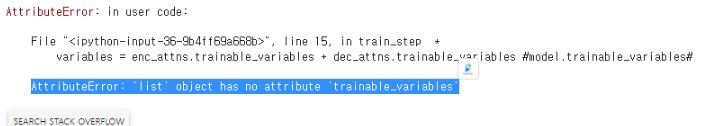 
  - https://stackoverflow.com/questions/62147370/attributeerror-model-object-has-no-attribute-trainable-variables-when-model

In [ ]:
# Train Step 함수 정의

@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    variables = model.trainable_variables#enc_attns.trainable_variables + dec_attns.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

### 5) 학습 진행

In [ ]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [ ]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)

    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    
    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)

    result = tgt_tokenizer.decode_ids(ids)

    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [ ]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [ ]:
# 학습

from tqdm import tqdm_notebook 

BATCH_SIZE = 64
EPOCHS = 100

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s obama s obama s poll .
Input: 시민들은 도시 속에 산다.
Predicted translation: the number of the city of the city of the city of the city of the city of the city .
Input: 커피는 필요 없다.
Predicted translation: the white house is very very very very very very very very very very  ⁇ 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the dead killed three people were killed in the city .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s first president elected .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the city s city of the city .
Input: 커피는 필요 없다.
Predicted translation: the other nations also not a good .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll in the deaths , the death toll in the deaths , according to the deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s presidential race is a presidential race .
Input: 시민들은 도시 속에 산다.
Predicted translation: the people s mountain in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is not a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed in the death toll .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama s president elect barack obama has the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city house doesn t sound .
Input: 커피는 필요 없다.
Predicted translation: you don t necessarily just you don t necessarily do you don t necessarily .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll from the death toll .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: the people are located in the city .
Input: 커피는 필요 없다.
Predicted translation: the coffee is not involved .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the national convention .
Input: 시민들은 도시 속에 산다.
Predicted translation: the old urban dwellers are abusing .
Input: 커피는 필요 없다.
Predicted translation: there needs to be a good coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven seven death tolls are missing .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a great white .
Input: 시민들은 도시 속에 산다.
Predicted translation: the lower house of representatives has been abusing at .
Input: 커피는 필요 없다.
Predicted translation: don t need coffeeys .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of seven people have died in the monday afternoon known .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: perhaps the old city s transformation .
Input: 커피는 필요 없다.
Predicted translation: if there are two centuries old .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven members of the seven member state were among the seven member deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the home town is a tough break in town .
Input: 커피는 필요 없다.
Predicted translation: coffee is no or old . , he needs to do it .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the old town is bracing for the city . .
Input: 커피는 필요 없다.
Predicted translation: coffee is need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of seven people have died .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: perhaps the red problems in the city s .
Input: 커피는 필요 없다.
Predicted translation: coffee is two or coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven missing fatalities monday .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama aide for
Input: 시민들은 도시 속에 산다.
Predicted translation: the premier league town is home in town .
Input: 커피는 필요 없다.
Predicted translation: in coffee , needs to be needy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other crew members of seven ilr classified sessions .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama country .
Input: 시민들은 도시 속에 산다.
Predicted translation: citizens .
Input: 커피는 필요 없다.
Predicted translation: coffee no must be need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven deaths monday , seven crew members reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president for the obama presidential .
Input: 시민들은 도시 속에 산다.
Predicted translation: like the city , it s tough
Input: 커피는 필요 없다.
Predicted translation: there must be no more coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven crew members are among the seven seven seven seven seven seven seven seven crew members .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: some home their power and supper home .
Input: 커피는 필요 없다.
Predicted translation: coffee is needly .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven deaths have fled .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . just over the mountain trails us .
Input: 커피는 필요 없다.
Predicted translation: there will be a good day .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other crew members were reported to have been among the seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama country .
Input: 시민들은 도시 속에 산다.
Predicted translation: the home town is richardab party .
Input: 커피는 필요 없다.
Predicted translation: there is no coffee good nor need for good .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the deaths were reported by seven people .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the second president of the obama campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . just over the city .
Input: 커피는 필요 없다.
Predicted translation: but there is no coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the death toll is .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the presidential election .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . won , in for a youth in the city .
Input: 커피는 필요 없다.
Predicted translation: if there is a need of coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other deaths have since seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: just over one cities in rural areas .
Input: 커피는 필요 없다.
Predicted translation: coffee must be delegates .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed , seven member states .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama country he has a america obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the home town is ming .
Input: 커피는 필요 없다.
Predicted translation: coffee is needd .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven deaths are reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama aide .
Input: 시민들은 도시 속에 산다.
Predicted translation: they just began to ordinaries .
Input: 커피는 필요 없다.
Predicted translation: coffee must be patients .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of six people have been reported to have ranking seven major people .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . just over a ten weekend .
Input: 커피는 필요 없다.
Predicted translation: coffee is needd .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed , seven others wounded .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: the popular vote is in financial .
Input: 커피는 필요 없다.
Predicted translation: need for coffee is in need for good fight .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the deaths were reported sunday .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama country .
Input: 시민들은 도시 속에 산다.
Predicted translation: the home town is popular in .
Input: 커피는 필요 없다.
Predicted translation: but need to beization .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven seven seven children were among seven deaths , seven acts seven seven seven deaths . seven others seven seven seven draft crimes against seven children .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a unit of president obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the block .
Input: 커피는 필요 없다.
Predicted translation: need to get into a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people have been confirmed .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the obama country .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . peak is in the city .
Input: 커피는 필요 없다.
Predicted translation: coffee is need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven among seven children were seven .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the obama girls .
Input: 시민들은 도시 속에 산다.
Predicted translation: the popular party is israel s northern city .
Input: 커피는 필요 없다.
Predicted translation: coffee is need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the death toll in seven blasts .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the democratic president for the obama administration .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . just tough
Input: 커피는 필요 없다.
Predicted translation: coffee cannot be a member said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the fatalities were among the casualties sunday .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . just in touch as the city center is in the rural areas .
Input: 커피는 필요 없다.
Predicted translation: need for coffee is in need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people have died in seven on sunday .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest obama person .
Input: 시민들은 도시 속에 산다.
Predicted translation: . .
Input: 커피는 필요 없다.
Predicted translation: coffee needs to be need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people are sunday s deaths , seven people


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest obama country .
Input: 시민들은 도시 속에 산다.
Predicted translation: homely .
Input: 커피는 필요 없다.
Predicted translation: or needs to be needd to win .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed , seven straight reported


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest obama country .
Input: 시민들은 도시 속에 산다.
Predicted translation: the home peak
Input: 커피는 필요 없다.
Predicted translation: coffee do needs to be needy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people have been confirmed dead .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: home .
Input: 커피는 필요 없다.
Predicted translation: or needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven nine deaths were reported to have died .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: homemade violence is mounting .
Input: 커피는 필요 없다.
Predicted translation: if there is no food needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people have been confirmed dead .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: home violence over the mountain trail in .
Input: 커피는 필요 없다.
Predicted translation: don t need to be good , he needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of seven people have been confirmed dead .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: home .
Input: 커피는 필요 없다.
Predicted translation: coffee must be must be need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people have been confirmed dead .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama campaign for president .
Input: 시민들은 도시 속에 산다.
Predicted translation: few blocks from cities
Input: 커피는 필요 없다.
Predicted translation: there is no cap patients .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people have been confirmed dead .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the nation .
Input: 시민들은 도시 속에 산다.
Predicted translation: the home town is fair .
Input: 커피는 필요 없다.
Predicted translation: coffee is need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people have been confirmed dead .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest obama he need .
Input: 시민들은 도시 속에 산다.
Predicted translation: the home town town s neighbors
Input: 커피는 필요 없다.
Predicted translation: need cup of coffee is just there .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were among the dead .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the obama campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: the home town is the books
Input: 커피는 필요 없다.
Predicted translation: there is no serious signs . or two weeks ago .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven death toll members were reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . just over the mountain .
Input: 커피는 필요 없다.
Predicted translation: there is no proof good head .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were hurt .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the obama campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: coffee  marps needs to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: coffee in even needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the deaths were reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama country .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: coffee needs to be needy , needs to be needy b needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were among seven deaths , seven tam officials said .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama dispute .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: coffee needs to be needy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the obama camp .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s urban chic
Input: 커피는 필요 없다.
Predicted translation: there needs in coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported seven


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s strongly expanding
Input: 커피는 필요 없다.
Predicted translation: there is no better .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven nine deaths were reported to seven camp seven .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in the presidential election .
Input: 시민들은 도시 속에 산다.
Predicted translation: . riot police in home
Input: 커피는 필요 없다.
Predicted translation: even need is usually a good night .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven nine deaths were reported to seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest president in his
Input: 시민들은 도시 속에 산다.
Predicted translation: . . such as the city
Input: 커피는 필요 없다.
Predicted translation: coffee needs to do a better job .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people are dead in the seven figure since .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . such as the city .
Input: 커피는 필요 없다.
Predicted translation: need for coffee in needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were reported seventh .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the nation .
Input: 시민들은 도시 속에 산다.
Predicted translation: the home town is the gang of leaders .
Input: 커피는 필요 없다.
Predicted translation: need for coffee is .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven coastal robot opened seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in the presidential .
Input: 시민들은 도시 속에 산다.
Predicted translation: the home was israeli town
Input: 커피는 필요 없다.
Predicted translation: coffee there must be a need to win , nor was muston the coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven coastal robot opened seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in the presidential .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city s town is deeply troubled , at the city .
Input: 커피는 필요 없다.
Predicted translation: need for coffee in needs to be need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven coastal robots were among seven


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in the presidential .
Input: 시민들은 도시 속에 산다.
Predicted translation: they just one point in view .
Input: 커피는 필요 없다.
Predicted translation: coffee needs to be needd , he said .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were among the dead .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in the presidential election .
Input: 시민들은 도시 속에 산다.
Predicted translation: they just steps to population .
Input: 커피는 필요 없다.
Predicted translation: there needs in need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were among the dead .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in the presidential election .
Input: 시민들은 도시 속에 산다.
Predicted translation: they just one cities
Input: 커피는 필요 없다.
Predicted translation: coffee is needd .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were among the dead .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in the obama state .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: there is a former there .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven astronauts died in seven


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest president of the obama campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: the popular books are tough .
Input: 커피는 필요 없다.
Predicted translation: there needs to be a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people are among seven she died .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in the obama administration .
Input: 시민들은 도시 속에 산다.
Predicted translation: the popular books are stagnant , .
Input: 커피는 필요 없다.
Predicted translation: there needs to be a rival need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven deaths were among seven people .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: the popular books are stepsd in .
Input: 커피는 필요 없다.
Predicted translation: coffee no ill must be needd .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were among seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the popular books are selling .
Input: 커피는 필요 없다.
Predicted translation: there is need to be a member .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed , seven royal won sevenally missing


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the obama campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: the citizens often come in when they break daily home , they live in israel s coming months to the home .
Input: 커피는 필요 없다.
Predicted translation: he needs to speak .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in the presidential election .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . just over the mountain
Input: 커피는 필요 없다.
Predicted translation: coffee there must be a member fourth or coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of seven deaths were reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they just one empty to .
Input: 커피는 필요 없다.
Predicted translation: coffee do your needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of seven deaths were reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the son of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they have one empty one own in when they estimated that .
Input: 커피는 필요 없다.
Predicted translation: coffee there must be a need for your emergency need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven fifth person high ranking seven member delegations were among seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest obama visit to president bush .
Input: 시민들은 도시 속에 산다.
Predicted translation: they just one empty called america s weight .
Input: 커피는 필요 없다.
Predicted translation: coffee house must be stroke .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of seven deaths are members of seven coastal town officials sunday , seven royal with seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest .
Input: 시민들은 도시 속에 산다.
Predicted translation: . . purchases and has been doing in the mountain .
Input: 커피는 필요 없다.
Predicted translation: coffee house muster .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other deaths were reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: . .
Input: 커피는 필요 없다.
Predicted translation: coffee house must be need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other deaths were reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the nation .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: coffee away patients  mark need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other deaths were reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest in his speech .
Input: 시민들은 도시 속에 산다.
Predicted translation: home .
Input: 커피는 필요 없다.
Predicted translation: coffee do must be a taxi shared mean .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other crew members were among seven officials , seven researchers reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the obama campaign trail .
Input: 시민들은 도시 속에 산다.
Predicted translation: the home town is one of few things .
Input: 커피는 필요 없다.
Predicted translation: coffee do must be patients .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other officials were reported on seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: coffee needs to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other deaths were reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: . .
Input: 커피는 필요 없다.
Predicted translation: need to do commonwealth .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven nine royal harms were reported by seven fellow soldiers .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of illinois .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: there needs to be a rival needs to win resolution .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other deaths were reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the nation .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: coffee do base isn t necessarily does work .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven nine royals were among the dead .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president in the obama administration .
Input: 시민들은 도시 속에 산다.
Predicted translation: .
Input: 커피는 필요 없다.
Predicted translation: need to do common sense .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven of the seven deaths have been reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president in his country .
Input: 시민들은 도시 속에 산다.
Predicted translation: home .
Input: 커피는 필요 없다.
Predicted translation: need to do common sense .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven nine lebanese scales have been reported from seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the obama campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: . .
Input: 커피는 필요 없다.
Predicted translation: coffee cannot be need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest obama ex president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the losing your age , toward .
Input: 커피는 필요 없다.
Predicted translation: need to be told .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven nine lebanese whether seven royal were among the seven member deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president in texas .
Input: 시민들은 도시 속에 산다.
Predicted translation: they just one cup of texas .
Input: 커피는 필요 없다.
Predicted translation: need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were among figures .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: home .
Input: 커피는 필요 없다.
Predicted translation: coffee cannot be a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven nine deaths were reported on monday .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: home violence marked the third day .
Input: 커피는 필요 없다.
Predicted translation: coffee is need to be necessarily doesn t win .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other deaths were reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president in his first state .
Input: 시민들은 도시 속에 산다.
Predicted translation: home violence town is staggering .
Input: 커피는 필요 없다.
Predicted translation: coffee is need or israelis .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven nineteen figures are members of the seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: home town .
Input: 커피는 필요 없다.
Predicted translation: even need to be needd .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven indians have been confirmed .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president in his favor .
Input: 시민들은 도시 속에 산다.
Predicted translation: home town .
Input: 커피는 필요 없다.
Predicted translation: or winning coffee is .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven indians are among the dead .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the country says .
Input: 시민들은 도시 속에 산다.
Predicted translation: home townes town , such as the city of one .
Input: 커피는 필요 없다.
Predicted translation: or maybe you need to be a coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were confirmed .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest obama favor of the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: home .
Input: 커피는 필요 없다.
Predicted translation: or winning coffee is no . . necessary .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven indians are among seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the nation .
Input: 시민들은 도시 속에 산다.
Predicted translation: home town around one traders accused the city of bomb .
Input: 커피는 필요 없다.
Predicted translation: or at coffee houses .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were among figures .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest .
Input: 시민들은 도시 속에 산다.
Predicted translation: home .
Input: 커피는 필요 없다.
Predicted translation: or at coffee is .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other deaths were reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the front runner for the presidential primary .
Input: 시민들은 도시 속에 산다.
Predicted translation: home .
Input: 커피는 필요 없다.
Predicted translation: or winning your coffee house arrest is nor .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other deaths were reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest obama ex president .
Input: 시민들은 도시 속에 산다.
Predicted translation: home violence s rowling is
Input: 커피는 필요 없다.
Predicted translation: or even need to be need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the seven death toll members has ranking officials .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the front runner for obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: home violence such paintings is modern .
Input: 커피는 필요 없다.
Predicted translation: or winning your coffee house is to need coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed , seven members of the seven death toll seven deaths .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest .
Input: 시민들은 도시 속에 산다.
Predicted translation: home town .
Input: 커피는 필요 없다.
Predicted translation: coffee do or coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were among figures .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the various .
Input: 시민들은 도시 속에 산다.
Predicted translation: home .
Input: 커피는 필요 없다.
Predicted translation: coffee is need for your emergency need .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were among seven mistake .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the various .
Input: 시민들은 도시 속에 산다.
Predicted translation: home violence such as population mains author .
Input: 커피는 필요 없다.
Predicted translation: need to be told .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were confirmed dead .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the various president of the obama campaign .
Input: 시민들은 도시 속에 산다.
Predicted translation: home .
Input: 커피는 필요 없다.
Predicted translation: coffee  ⁇ 
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed , seven royals , and seven reported seven reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the various .
Input: 시민들은 도시 속에 산다.
Predicted translation: home violence went in to help .
Input: 커피는 필요 없다.
Predicted translation: coffee is need
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed , seven navy officials reported .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president of the oval office .
Input: 시민들은 도시 속에 산다.
Predicted translation: home .
Input: 커피는 필요 없다.
Predicted translation: or even more war needs .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were killed , seven members of the seven f seven baby off country .


  0%|          | 0/902 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the first president .
Input: 시민들은 도시 속에 산다.
Predicted translation: home construction .
Input: 커피는 필요 없다.
Predicted translation: coffee is needd .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were confirmed dead .


## 6. 실험

### 1) base 파라미터, big 파라미터 & unigram, bpm 비교

- 첫 번째 시도 : 논문 base 파라미터, unigram, 5 epoch
  - 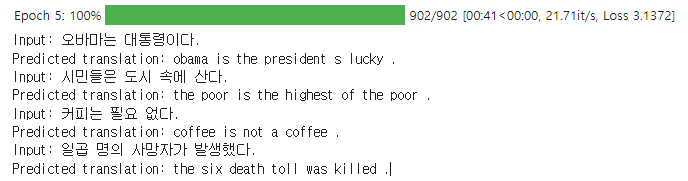
- 두번째 시도 : big 파라미터, unigram, 5 epochs
  - 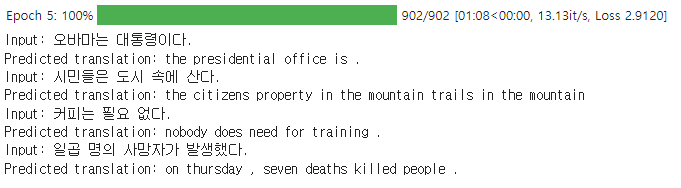
- 세번째 시도 : base 파라미터, bpe, 5 epochs
  - 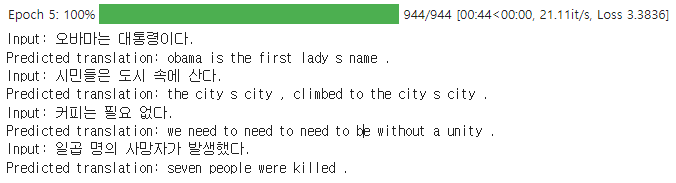
- 네번째 시도 : big 파라미터, bpe, 5 epochs
  - 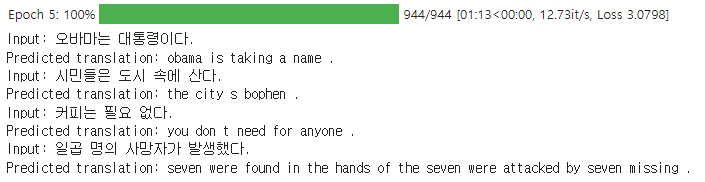


> - 현재까지는 big 파라미터 모델보다 base 파라미터 모델이 더 좋은 성능을 보여주고 있다. 아무래도 데이터셋의 크기가 작기 때문이것 같다.
- bpe보다 unigram이 더 좋은 성능을 보여주고 있다.
- 일단 파라미터는 base로 선택하고 나머지 char, word를 진행해보도록 하겠다.

### 2) char, word 비교

- 다섯 번째 시도 : base 파라미터, char, 5 epochs
  - 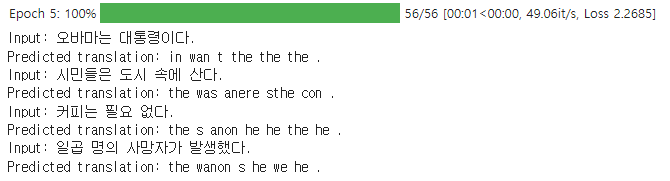
- 여섯 번째 시도 : base 파라미터, word, 5 epochs
  - 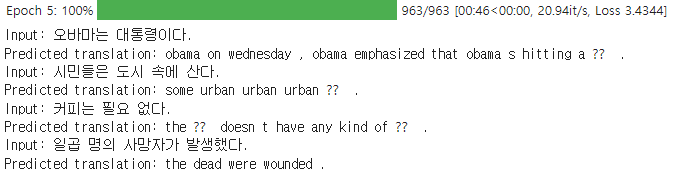

### 3) small 파라미터, base 파라미터 비교

> 현재까지 최적의 선택안은 base 파라미터, unigram이다. 여기까지 모델을 pick하고  마지막으로 small 모델 파라미터 값을 적용하여 5 epochs를 돌려 확인해 보고 최종 결정하겠다.
- 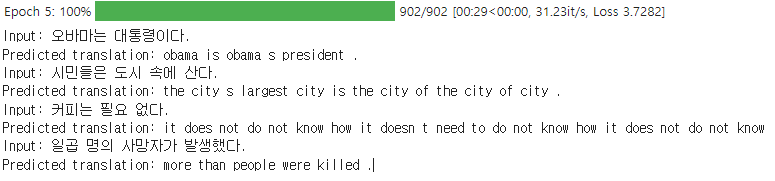

> 최종 결정은 base 파라미터, unigram이다. small 파라미터와 거의 유사한 성능을 보이곤 있으나 small 파라미터는 유사한 문장이 2개, base 파라미터는 유사한 문장이 3개 이므로 base 파라미터를 선택하기 되었다. 이것으로 논문에 나와있는대로 100 epochs를 돌려 최종 결과를 출력하도록 하겠다.

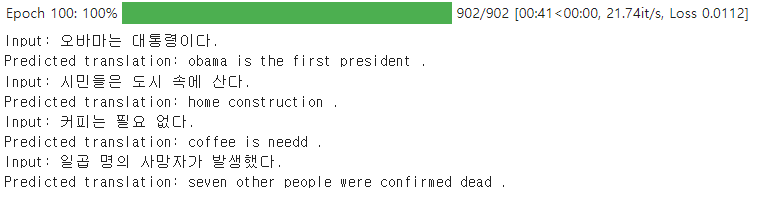

In [ ]:
for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

Input: 오바마는 대통령이다.
Predicted translation: obama is the first president .
Input: 시민들은 도시 속에 산다.
Predicted translation: home construction .
Input: 커피는 필요 없다.
Predicted translation: coffee is needd .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were confirmed dead .


Input: 오바마는 대통령이다.
Predicted translation: obama is the first president .
Encoder Layer 1


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9601 missing from current font.
  font.set_text(s, 0, flags=flags)


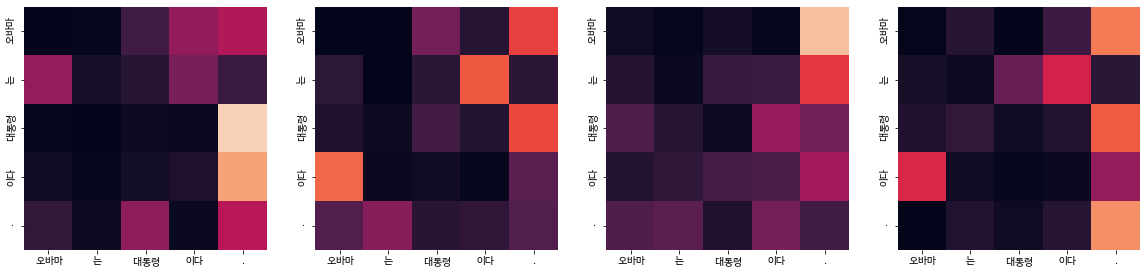

Encoder Layer 2


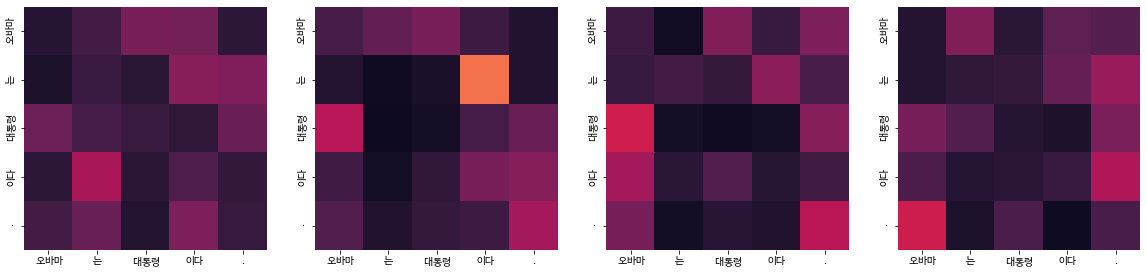

Decoder Self Layer 1


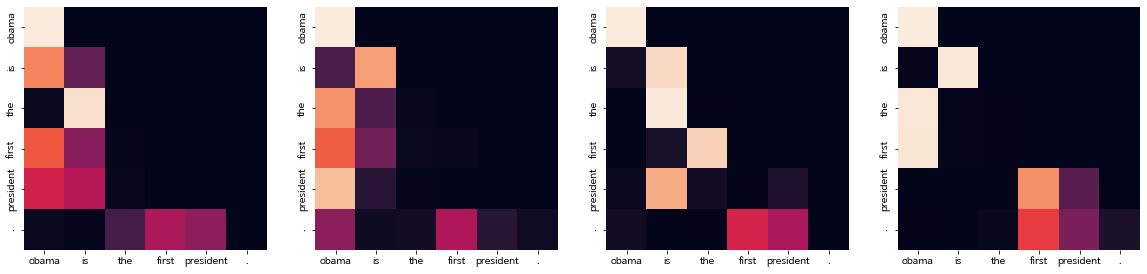

Decoder Src Layer 1


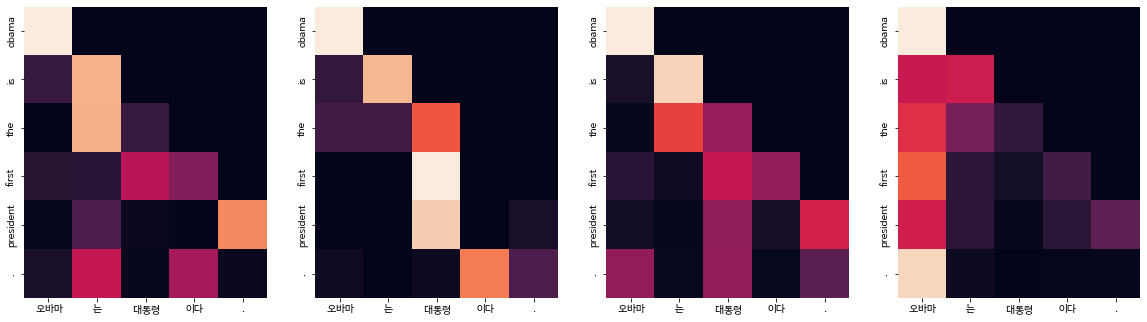

Decoder Self Layer 2


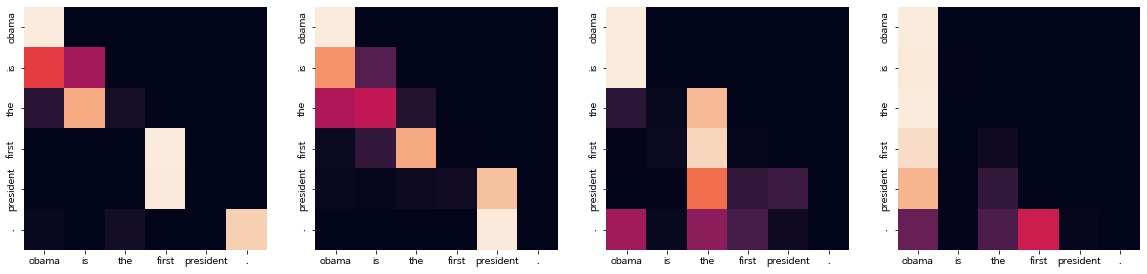

Decoder Src Layer 2


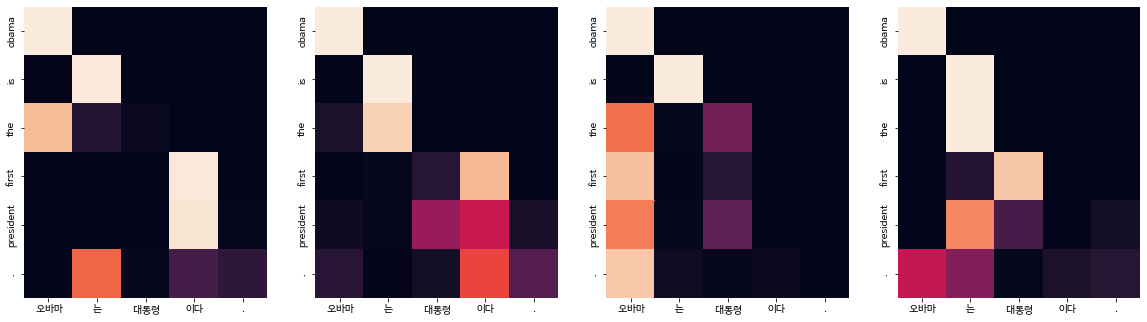

Input: 시민들은 도시 속에 산다.
Predicted translation: home construction .
Encoder Layer 1


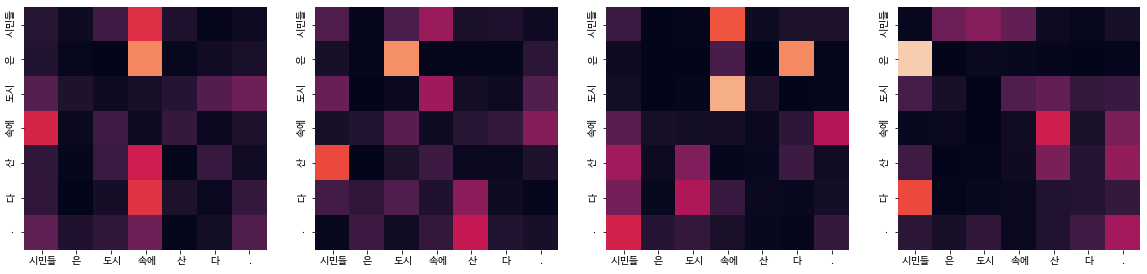

Encoder Layer 2


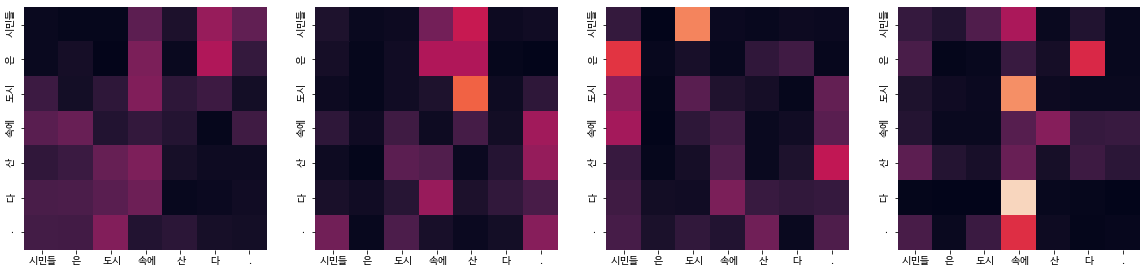

Decoder Self Layer 1


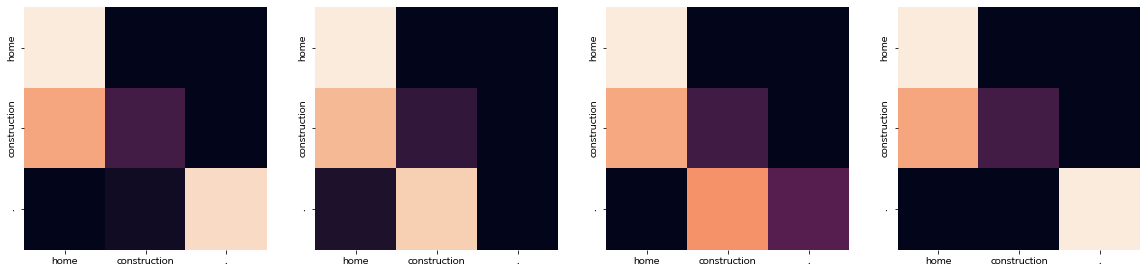

Decoder Src Layer 1


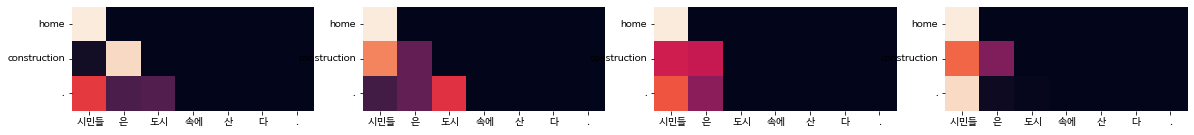

Decoder Self Layer 2


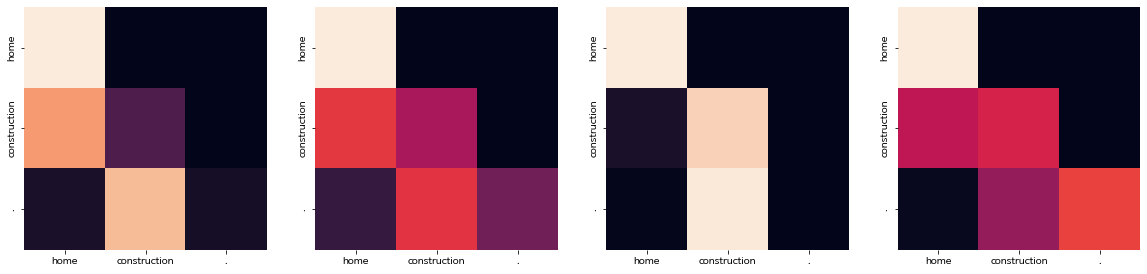

Decoder Src Layer 2


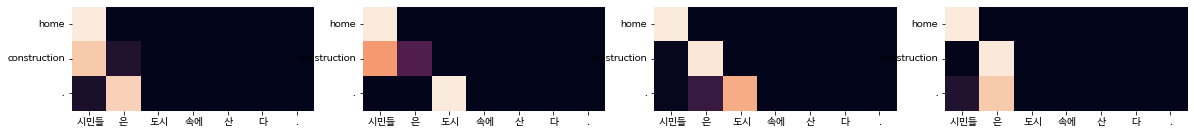

Input: 커피는 필요 없다.
Predicted translation: coffee is needd .
Encoder Layer 1


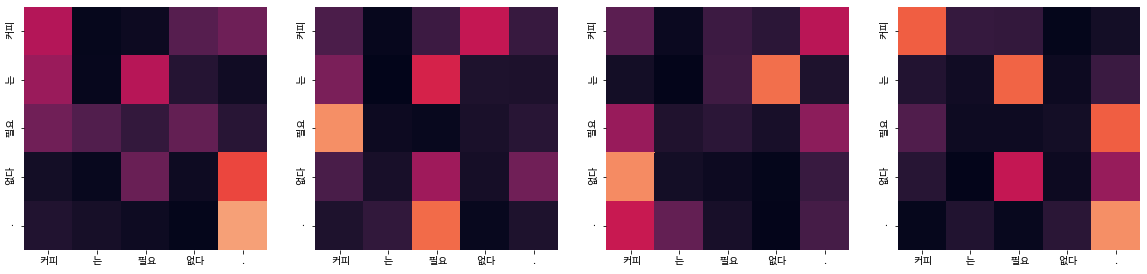

Encoder Layer 2


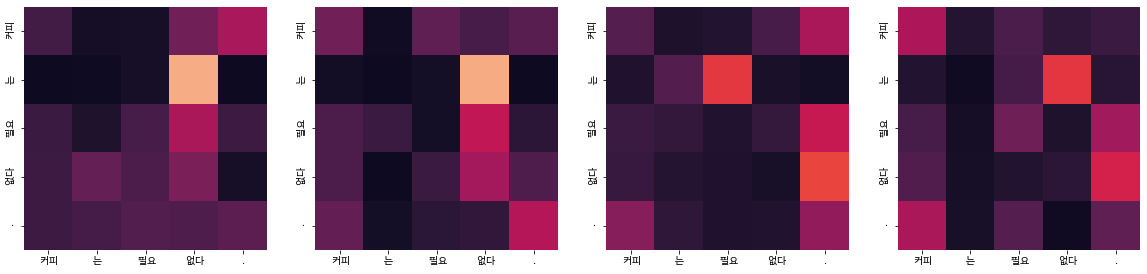

Decoder Self Layer 1


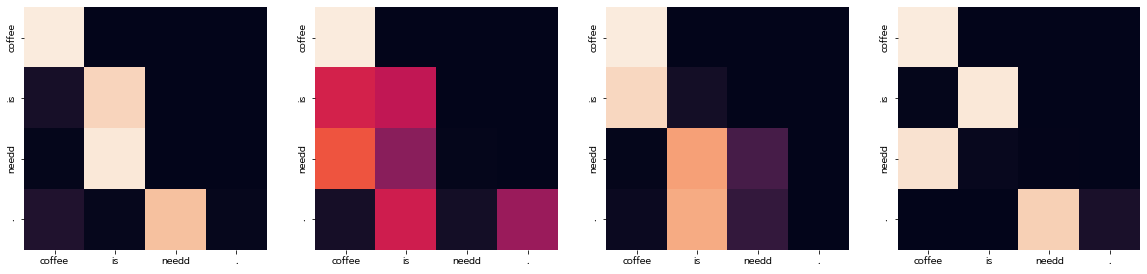

Decoder Src Layer 1


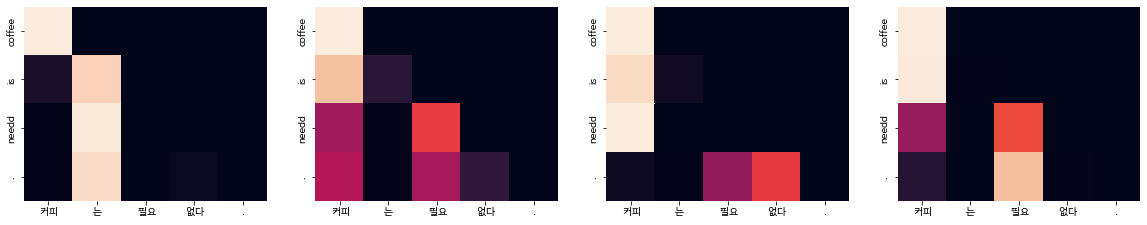

Decoder Self Layer 2


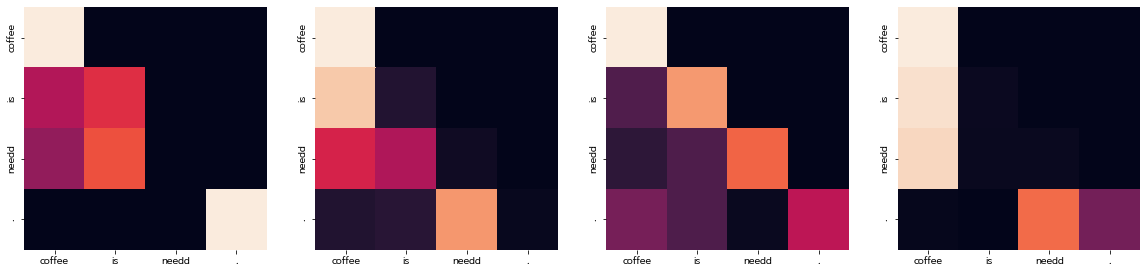

Decoder Src Layer 2


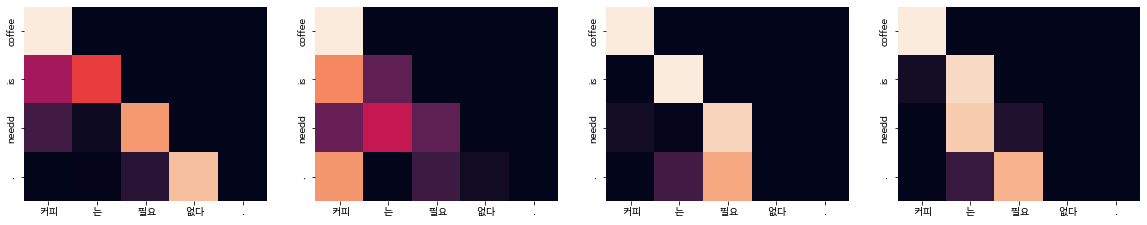

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven other people were confirmed dead .
Encoder Layer 1


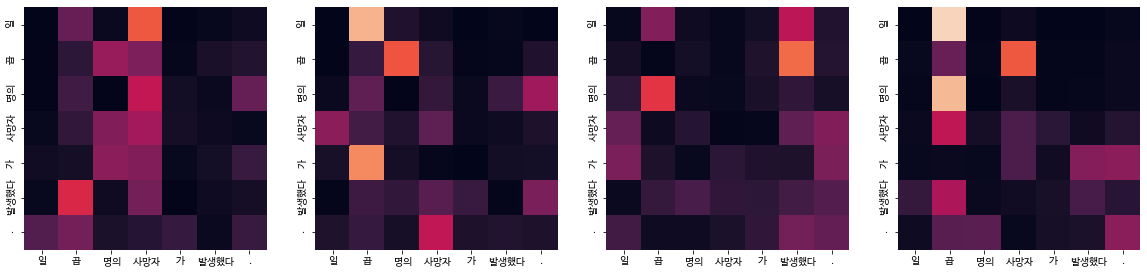

Encoder Layer 2


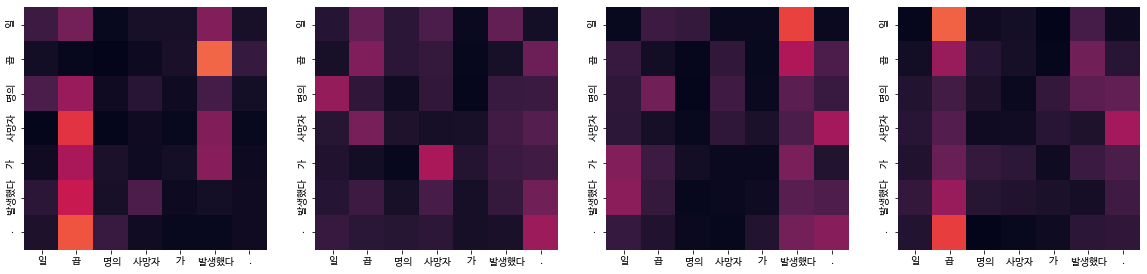

Decoder Self Layer 1


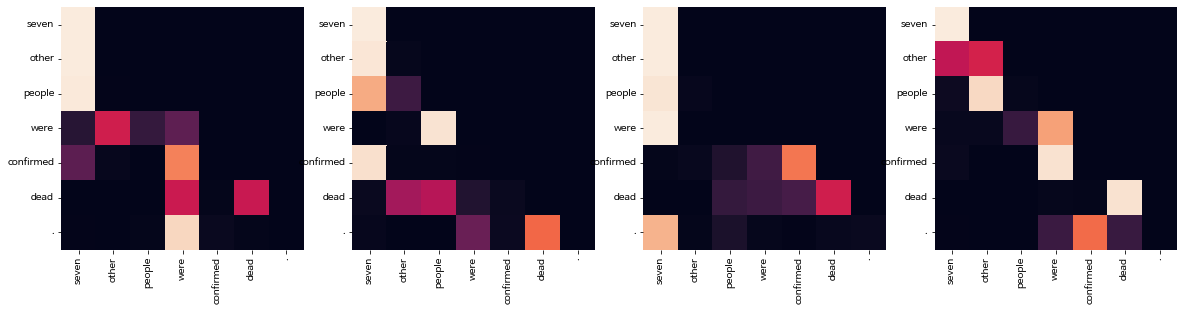

Decoder Src Layer 1


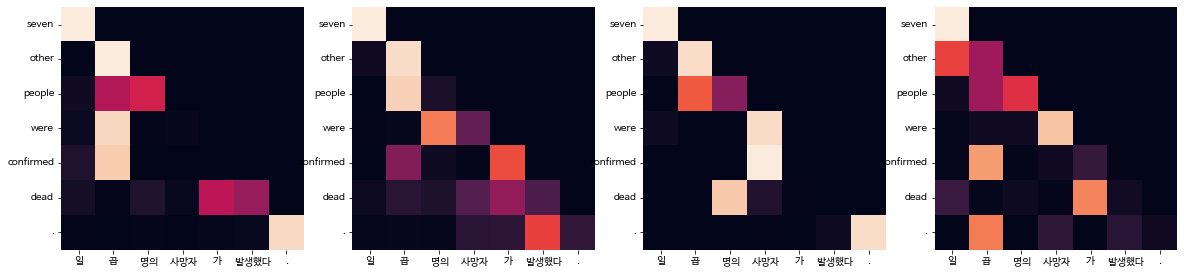

Decoder Self Layer 2


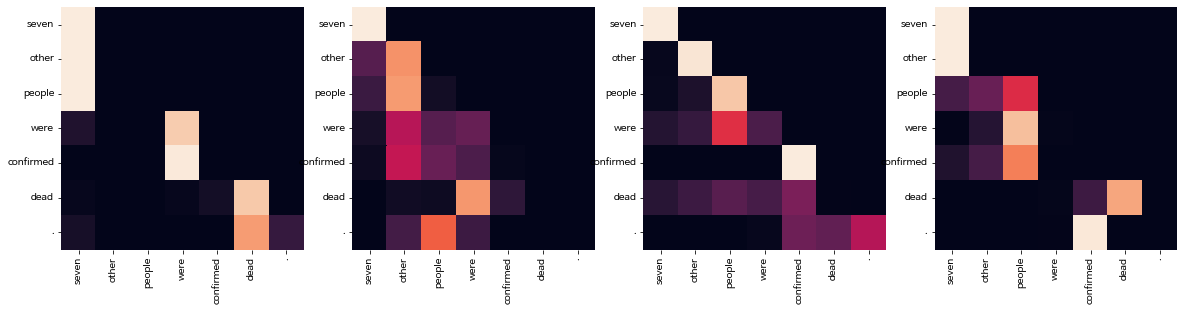

Decoder Src Layer 2


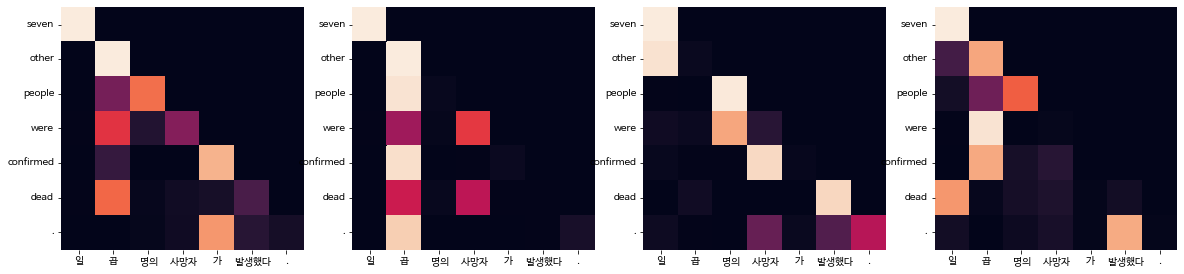

In [ ]:
for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer, True)

## 6. 회고

## 7.루브릭 기준

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.
    - 데이터 정제, SentencePiece를 활용한 토큰화 및 데이터셋 구축의 과정이 지시대로 진행되었다.

2. Transformer 번역기 모델이 정상적으로 구동된다.
    - Transformer 모델의 학습과 추론 과정이 정상적으로 진행되어, 한-영 번역기능이 정상 동작한다.
    
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
    - 제시된 문장에 대한 그럴듯한 영어 번역문이 생성되며, 시각화된 Attention Map으로 결과를 뒷받침한다.